# **BBC-TEXT CLASSIFICATION**

## Problem
Classify the [BBC text]() (cleaned).

## Initialize

In [1]:
import os
import io
import warnings

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, GlobalAveragePooling1D, Bidirectional, LSTM, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard

In [2]:
# set random seeds
np.random.seed(0)
tf.random.set_seed(0)

# show figures inline
%matplotlib inline

# ignore all warning (NOT recommended)
warnings.filterwarnings("ignore")

**Global inputs**

In [3]:
EMBED_DIMS = 100
MAX_LENGTH = 120
TRUNC_TYPE = 'post'
PAD_TYPE = 'post'

TRAIN_SPLIT = 0.8

LOG_DIR = '01-logs'
PROBLEM = 'bbc'

## Dataset
**Get the dataset**

In [4]:
data_url = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv'
path_out = '../.tmp/bbc-text.csv'

# download the dataset
if not os.path.exists(path_out):
    os.system(f"""wget --no-check-certificate {data_url} -O {path_out}""")

# read the csv file
df = pd.read_csv(path_out)

df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


**Data preparation**

In [5]:
# extract the columns
sentences = df['text'].to_numpy()
labels = df['category'].to_numpy()

# number of unique labels
class_names = set(labels)

# examine the dataset
print(f'shape - sentences: {sentences.shape}, {labels.shape}')
print(f'unique labels - {class_names}, total: {len(class_names)}')

shape - sentences: (2225,), (2225,)
unique labels - {'sport', 'politics', 'tech', 'entertainment', 'business'}, total: 5


**Data cleaning**
- Remove the stop words from the sentences.

In [6]:
# list of stopwords
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "s", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

# convert to a dictionary
dict_to_replace = {f' {word} ': ' ' for word in stopwords}

# replace the stopwords
df['text'] = df['text'].replace(dict_to_replace, regex=True)

# check
df['text'].head()

0    tv future hands viewers home theatre systems  ...
1    worldcom boss  left books alone  former worldc...
2    tigers wary farrell  gamble  leicester say wil...
3    yeading face newcastle fa cup premiership side...
4    ocean twelve raids box office ocean twelve  cr...
Name: text, dtype: object

**Shuffle and split**

In [7]:
# get randomly shuffled indices
idc = np.arange(len(sentences))
np.random.shuffle(idc)

# shuffle the dataset
sentences = sentences[idc]
labels = labels[idc]

In [8]:
# number of training samples
num_train = int(TRAIN_SPLIT *  len(sentences))

# training subset
train_sentences = sentences[:num_train]
train_labels = labels[:num_train]

# validation subset
validation_sentences = sentences[num_train:]
validation_labels = labels[num_train:]

# check the size
print(f'training samples: {len(train_sentences)}')
print(f'validation samples: {len(validation_sentences)}')

training samples: 1780
validation samples: 445


## Pre-processing

**Training data**

In [9]:
# initiate a tokenizer
tokenizer = Tokenizer(oov_token='<OOV>')
# update the vocabulary on training texts
tokenizer.fit_on_texts(train_sentences)

# vocabulary
word_index = tokenizer.word_index
vocab_size = len(word_index)

# get sequences
train_sequences = tokenizer.texts_to_sequences(train_sentences)
# padding
train_padded = pad_sequences(train_sequences, padding=PAD_TYPE, maxlen=MAX_LENGTH, truncating=TRUNC_TYPE)

print(train_padded.shape)

(1780, 120)


**Validation data**

In [10]:
# get sequences
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
# padding
validation_padded = pad_sequences(validation_sequences, padding=PAD_TYPE, maxlen=MAX_LENGTH, truncating=TRUNC_TYPE)

print(validation_padded.shape)

(445, 120)


**Labels**

In [11]:
# tokenize the labels
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(train_labels)

# get the sequences
training_label_seq = label_tokenizer.texts_to_sequences(train_labels)
validation_label_seq = label_tokenizer.texts_to_sequences(validation_labels)

# convert to numpy
training_label_seq = np.array(training_label_seq).squeeze() - 1
validation_label_seq = np.array(validation_label_seq).squeeze() - 1

# see some example
print(training_label_seq[:5], '...', training_label_seq.shape)

[2 1 1 1 1] ... (1780,)


## Pre-trained Embeddings

**GloVe**
([See more](https://nlp.stanford.edu/projects/glove/))


In [12]:
data_url = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt'
path_out = '../.tmp/glove.6B.100d.txt'
save_mat = LOG_DIR + '/' + PROBLEM + '-glove_embedding.npy'

# download the dataset
if not os.path.exists(path_out):
    os.system(f"""wget --no-check-certificate {data_url} -O {path_out}""")

if os.path.exists(save_mat):
    embeddings_matrix = np.load(save_mat)
else:
    embeddings_index = {}
    with open(path_out, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embeddings_matrix = np.zeros((vocab_size+1, EMBED_DIMS))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embeddings_matrix[i] = embedding_vector

    np.save(save_mat, embeddings_matrix)

# pre-trained embeddings
print(embeddings_matrix.shape)

(27219, 100)


## Model

In [13]:
# input layer
input_tensor = Input(shape=MAX_LENGTH)

# pre-trained embedding layer
x = Embedding(
    input_dim=embeddings_matrix.shape[0],
    output_dim=embeddings_matrix.shape[1],
    input_length=MAX_LENGTH,
    weights=[embeddings_matrix],
    trainable=False
)(input_tensor)

# hidden layers
x = Dropout(0.2)(x)
x = Conv1D(64, 5, activation='relu')(x)
x = MaxPooling1D(pool_size=4)(x)
x = LSTM(64)(x)

# output layer
output_tensor = Dense(5, activation='softmax')(x)

# model
model = tf.keras.Model(input_tensor, output_tensor)

# compile
model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

# model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 120, 100)          2721900   
_________________________________________________________________
dropout (Dropout)            (None, 120, 100)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 64)           32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 29, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 5)                 325   

## Train

**Callbacks**

In [14]:
# reduce learning rate
reduce_rl = ReduceLROnPlateau(
    monitor='val_acc', mode='max', factor=0.1, patience=3, verbose=2
)

# stop training
early_stopping = EarlyStopping(
    monitor='val_acc',  mode='max', min_delta=0, patience=10, verbose=2, restore_best_weights=True
)

**Star Training**

In [15]:
# train the model
hist = model.fit(
    train_padded, training_label_seq,
    batch_size=250,
    validation_data=(validation_padded, validation_label_seq),
    epochs=30,
    verbose=1,
    callbacks=[reduce_rl, early_stopping]
)

Train on 1780 samples, validate on 445 samples
Epoch 1/30
1780/1780 [==============================] - 9s 5ms/sample - loss: 1.4494 - acc: 0.4466 - val_loss: 1.1757 - val_acc: 0.6966
Epoch 2/30
1780/1780 [==============================] - 0s 122us/sample - loss: 0.9510 - acc: 0.7736 - val_loss: 0.6947 - val_acc: 0.8427
Epoch 3/30
1780/1780 [==============================] - 0s 117us/sample - loss: 0.5122 - acc: 0.8854 - val_loss: 0.3547 - val_acc: 0.9213
Epoch 4/30
1780/1780 [==============================] - 0s 120us/sample - loss: 0.3005 - acc: 0.9140 - val_loss: 0.2351 - val_acc: 0.9303
Epoch 5/30
1780/1780 [==============================] - 0s 109us/sample - loss: 0.2161 - acc: 0.9258 - val_loss: 0.2185 - val_acc: 0.9348
Epoch 6/30
1780/1780 [==============================] - 0s 94us/sample - loss: 0.1733 - acc: 0.9433 - val_loss: 0.1768 - val_acc: 0.9393
Epoch 7/30
1780/1780 [==============================] - 0s 107us/sample - loss: 0.1454 - acc: 0.9601 - val_loss: 0.1943 - val_ac

**Show training graphs**

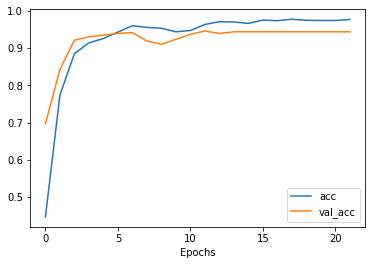

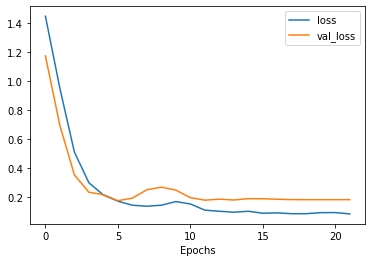

In [16]:
def plot_graphs(history, metrics):
    plt.figure()
    for metric in metrics:
        plt.plot(history.history[metric], label=metric)
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()

plot_graphs(hist, ["acc", "val_acc"])
plot_graphs(hist, ["loss", "val_loss"])

##Save Learned Embeddings

**vector and metadata**

In [17]:
# index to word dictionary
reverse_word_index = dict([(value, key) for (key, value) in tokenizer.word_index.items()])

# get the weights in the embedding layers
weights = model.layers[1].get_weights()[0]

out_v = io.open(LOG_DIR + '/' + PROBLEM + '-vecs.tsv', 'w', encoding='utf-8')
out_m = io.open(LOG_DIR + '/' + PROBLEM + '-meta.tsv', 'w', encoding='utf-8')

for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")

out_v.close()
out_m.close()

**Visualize**
- Go to [tensorflor embedding projector](http://projector.tensorflow.org/).
- Upload the `vecs.tsv` and `meta.tsv` files and see the embeddings.